LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [ ]:
%%bash
FILE=/content/portfolio_tools.py
if [[ ! -f $FILE ]]; then
    wget https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
fi

In [ ]:
!pip install mosek 
!export PYTHONPATH="$PYTHONPATH:/content"

# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem. 
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.

In [14]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import brentq
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [ ]:
# Colab additional settings
os.environ['MOSEKLM_LICENSE_FILE']="/content:/root/mosek"

In [15]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib: 3.4.3


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [16]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = ["SPY", "IWM"]
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [17]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [18]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_IWM.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [19]:
# |x| <= t
def absval(M, x, t):
    M.constraint(Expr.add(t, x), Domain.greaterThan(0.0))
    M.constraint(Expr.sub(t, x), Domain.greaterThan(0.0))
    
    
def sqrtm_symm(m):
    e, v = np.linalg.eigh(m)
    sqrt_e = np.sqrt(e)
    sqrt_m = np.dot(v, np.dot(np.diag(sqrt_e), v.T))
    return sqrt_m

    
def EfficientFrontier(N, mu0, gamma, beta0, Gmx, rho, diag_S_theta_upper, Q0, Nmx, zeta, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Get number of factors
        K = Q0.shape[0]
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))
        z = M.variable("z", N, Domain.greaterThan(0.0))
        
        # Constrain absolute value
        absval(M, x, z)
        
        # The variable t1 and t2 models the factor and specific portfolio variance terms.
        t1 = M.variable("t1", 1, Domain.greaterThan(0.0))
        t2 = M.variable("t2", 1, Domain.greaterThan(0.0))
        
        # The variables tau, s, u help modeling the factor risk.
        tau = M.variable("tau", 1, Domain.greaterThan(0.0))
        s = M.variable("s", 1, Domain.greaterThan(0.0))
        u = M.variable("u", K, Domain.greaterThan(0.0))
    
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1.0))
        
        # Objective (variance minimization)
        delta = M.parameter()
        wc_return = Expr.sub(Expr.dot(mu0, x), Expr.dot(gamma, z))
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(wc_return, Expr.mul(delta, Expr.add(t1, t2))))
                       
        # Risk constraint (specific)
        M.constraint('spec-risk', Expr.vstack(t2, 0.5, Expr.mulElm(np.sqrt(diag_S_theta_upper), x)), Domain.inRotatedQCone())
                    
        # Risk constraint (factor)
        siG = sqrtm_symm(np.linalg.inv(Gmx))            
        H = siG @ (Q0 + zeta * Nmx) @ siG 
        lam, V = np.linalg.eigh(H)
        w = Expr.mul(V.T @ sqrtm_symm(H) @ sqrtm_symm(Gmx) @ beta0.T, x)
        M.constraint('fact-risk-1', Expr.sub(t1, Expr.add(tau, Expr.sum(u))), Domain.greaterThan(0.0))
        M.constraint('fact-risk-2', Expr.sub(s, 1.0 / lam[-1]), Domain.lessThan(0.0))
        M.constraint('fact-risk-3', Expr.vstack(s, Expr.mul(0.5, tau), Expr.dot(rho, z)), Domain.inRotatedQCone())
        col1 = Expr.sub(Expr.constTerm(K, 1.0), Expr.mulElm(Expr.repeat(s, K, 0), lam))
        M.constraint('fact-risk-4', Expr.hstack(col1, Expr.mul(0.5, u), w), Domain.inRotatedQCone())
    
        # Create DataFrame to store the results. Last security names (the factors) are removed.
        columns = ["delta", "obj", "return", "risk", "zdiff"] + df_prices.columns[:-K].tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d)
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = mu0 @ x.level() - gamma @ z.level()
            portfolio_risk = np.sqrt((t1.level() + t2.level())[0])
            zdiff = np.sum(np.abs(x.level()) - z.level())
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, zdiff] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

        return df_result

## Define the factor model

We create a function to make scenarios. The input is the expected return and covariance of yearly logarithmic returns. The reason for this is that it is easier to generate logarithmic return scenarios from normal distribution than generating linear return scenarios from lognormal distribution.  

In [20]:
def scenarios(m_log, S_log, factor_num):
    """
    It is assumed that the last factor_num coordinates correspond to the factors.
    """
    if factor_num < 1: 
        raise Exception("Does not make sense to compute a factor model without factors!")
    
    # Generate logarithmic return scenarios
    scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, 100000)
    
    # Convert logarithmic return scenarios to linear return scenarios 
    scenarios = np.exp(scenarios_log) - 1
    
    R = scenarios[:, :-factor_num]
    F = scenarios[:, -factor_num:]
    
    return R, F

Next we define a function that computes the factor model
$$
R_t = \mu + \beta F_{t} + \theta_t.
$$

The function can handle any number of factors, and returns estimates $\EMean$, $\EBeta$, $\ECov_F$, $\ECov_\theta$, and the factor return matrix. The factors are assumed to be at the last coordinates of the data. 

In [21]:
def factor_model(R, F):
    """
    It is assumed that the last factor_num coordinates correspond to the factors.
    """
    factor_num = F.shape[1]
    
    # Do linear regression 
    params = []
    resid = []
    X = F
    X = sm.add_constant(X, prepend=True)
    
    for k in range(N):
        y = R[:, k]
        model = sm.OLS(y, X, hasconst=True).fit()        
        resid.append(model.resid)        
        params.append(model.params)
    resid = np.array(resid)
    params = np.array(params)
    

    # Get parameter estimates
    mu = params[:, 0]
    B = params[:, 1:]
    
    S_F = np.atleast_2d(np.cov(X[:, 1:].T))  # MLE computed from data
    S_theta = np.cov(resid, ddof=factor_num + 1)   
    diag_S_theta = np.diag(S_theta)
    
    return mu, B, S_F, diag_S_theta, X 

Finally, we define functions that will compute the parametrization for the uncertainty sets of the factor model parameters. 

In [22]:
def unc_mu(mu_est, diag_S_theta_est, A, omega):
    K = A.shape[1] - 1
    T = A.shape[0]
    iAA = np.linalg.inv(A.T @ A)
    c = stats.f.ppf(omega, K + 1, T - K - 1)

    # Parametrization
    mu0 = mu_est
    gamma = np.sqrt(diag_S_theta_est) * np.sqrt((K + 1) * iAA[0, 0] * c)
    
    return mu0, gamma

def unc_beta(beta_est, diag_S_theta_est, A, omega):
    K = A.shape[1] - 1
    T = A.shape[0]
    F = A[:,1:].T
    F1 = F @ np.ones((T, 1))
    c = stats.f.ppf(omega, K + 1, T - K - 1)

    # Parametrization
    beta0 = beta_est
    Q = np.array([[0, 1, 0], [0, 0, 1]])
    iAA = np.linalg.inv(A.T @ A)
    Gmx = F @ F.T - F1 @ F1.T / T
    rho = np.sqrt(diag_S_theta_est) * np.sqrt((K + 1) * c)
    
    return beta0, Gmx, rho

def unc_d(diag_S_theta_est, percent):    
    # Here we just add a percentage to the estimated error variance, to get an upper bound estimate. 
    diag_S_theta_upper = diag_S_theta_est * (1.0 + percent)
    return diag_S_theta_upper

def unc_q(S_F, A, omega):
    T = A.shape[0]
      
    
    def fun(eta, T, omega):
        return stats.gamma.cdf(1 + eta, (T + 1) / 2, scale=2 / (T - 1)) - \
               stats.gamma.cdf(1 - eta, (T + 1) / 2, scale=2 / (T - 1)) - \
               omega
    

    eta = brentq(fun, 0, 1, args=(T, omega))
    
    # Parametrization
    Q0 = S_F
    Nmx = S_F
        
    zeta = eta / (1 - eta)
    return Q0, Nmx, zeta

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [23]:
# Number of factors
fnum = len(list_factors)

# Number of securities (We subtract fnum to account for factors at the end of the price data)
N = df_prices.shape[1] - fnum

Now we compute the same using the factor model. First we compute logarithmic return statistics and use them to compute the factor exposures and covariances. 

In [24]:
m_log, S_log = compute_inputs(df_prices, return_log=True)
R, F = scenarios(m_log, S_log, fnum)

# Center factors, so we have the same model as in the article (Goldfarb--Iyengar 2003). 
F -= F.mean(axis=0)

# Compute factor model
mu, B, S_F, diag_S_theta, X = factor_model(R, F)

We compute the parameters of the uncertainty sets.

In [25]:
# Uncertainty set parameters
omega = 0.95
percent = 0.2
mu0, gamma = unc_mu(mu, diag_S_theta, X, omega)
beta0, Gmx, rho = unc_beta(B, diag_S_theta, X, omega)
diag_S_theta_upper = unc_d(diag_S_theta, percent)
Q0, Nmx, zeta = unc_q(S_F, X, omega)

# To get back the non_robust case, we have to zero the bounds
gamma_z = np.zeros(N)
rho_z = np.zeros(N)
zeta_z = 0.0

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{2}$. We compute the efficient frontier this way both with and without using factor model. 

In [26]:
# Compute efficient frontier with and without factor model
deltas = np.logspace(start=-1, stop=2, num=20)[::-1] / 2
df_result_orig = EfficientFrontier(N, mu0, gamma_z, beta0, Gmx, rho_z, diag_S_theta_upper, Q0, Nmx, zeta_z, deltas)
df_result_robust = EfficientFrontier(N, mu0, gamma, beta0, Gmx, rho, diag_S_theta_upper, Q0, Nmx, zeta, deltas)
df_result_orig

,delta,obj,return,risk,zdiff,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,50.000000,-1.963011,0.166737,0.206385,0.0,1.166168e-01,1.473706e-01,2.789160e-01,2.004959e-01,8.926464e-09,6.577475e-02,5.658599e-02,1.342400e-01
1,34.759640,-1.312790,0.173682,0.206795,0.0,1.086712e-01,1.431518e-01,2.767043e-01,1.898222e-01,2.063415e-08,8.340493e-02,6.552252e-02,1.327230e-01
2,24.164651,-0.858179,0.183676,0.207641,0.0,9.724220e-02,1.370804e-01,2.735150e-01,1.744604e-01,3.521223e-08,1.087845e-01,7.837979e-02,1.305377e-01
3,16.799091,-0.538423,0.198055,0.209381,0.0,8.080884e-02,1.283463e-01,2.689221e-01,1.523550e-01,3.474531e-08,1.453084e-01,9.686674e-02,1.273926e-01
4,11.678607,-0.310775,0.219299,0.213046,0.0,5.689619e-02,1.153949e-01,2.619704e-01,1.202415e-01,3.024147e-03,1.969154e-01,1.230439e-01,1.225136e-01
5,8.118884,-0.143863,0.254343,0.221465,0.0,2.035281e-02,9.370146e-02,2.491199e-01,7.143395e-02,3.111944e-02,2.641215e-01,1.574606e-01,1.126904e-01
6,5.644189,-0.015299,0.298891,0.235936,0.0,4.299772e-08,5.702187e-02,2.234612e-01,7.531158e-07,6.938467e-02,3.535480e-01,2.029646e-01,9.361888e-02
7,3.923800,0.086856,0.338987,0.253489,0.0,1.492498e-08,2.092341e-07,1.473377e-01,2.308300e-08,1.153779e-01,4.545953e-01,2.432316e-01,3.945738e-02
8,2.727797,0.170403,0.379125,0.276616,0.0,9.590732e-09,2.339015e-08,4.524015e-07,1.137332e-08,1.685260e-01,5.615656e-01,2.699078e-01,5.726565e-08
9,1.896345,0.234958,0.385263,0.281532,0.0,1.588257e-10,2.240931e-10,3.481956e-10,1.419420e-10,2.054034e-01,5.925224e-01,2.020743e-01,3.069764e-10


In [27]:
# Set small negatives to zero to make plotting work
mask = df_result_orig < 0
mask.iloc[:, :-8] = False
df_result_orig[mask] = 0

# Set small negatives to zero to make plotting work
mask = df_result_robust < 0
mask.iloc[:, :-8] = False
df_result_robust[mask] = 0

## Visualize the results

Plot the efficient frontier for both cases.

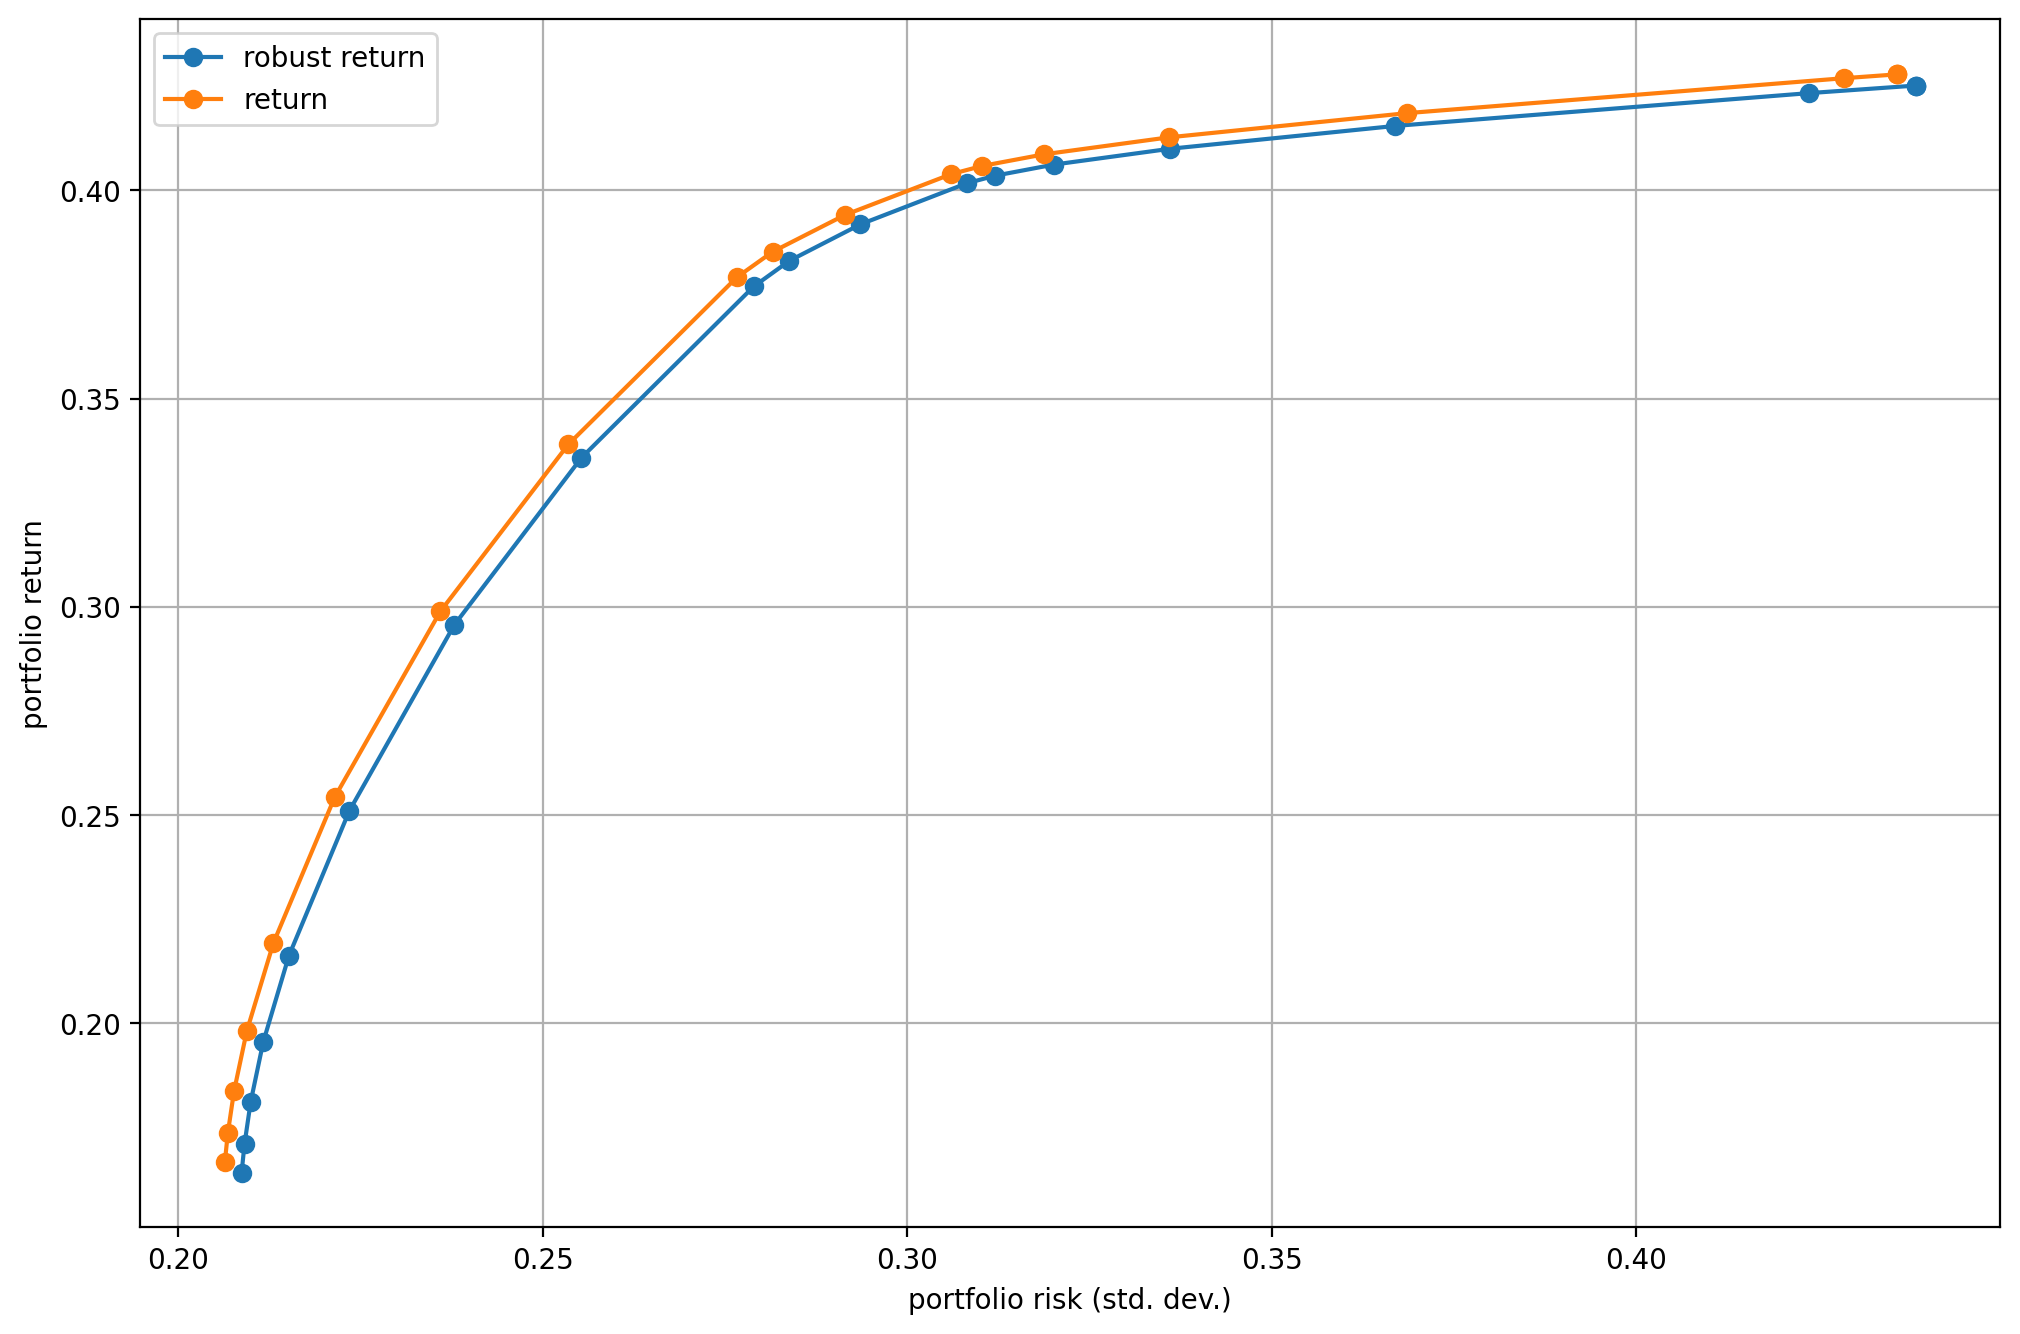

In [28]:
ax = df_result_robust.plot(x="risk", y="return", style="-o", xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
df_result_orig.plot(ax=ax, x="risk", y="return", style="-o", xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)   
ax.legend(["robust return", "return"]);

Plot the portfolio composition for both cases.

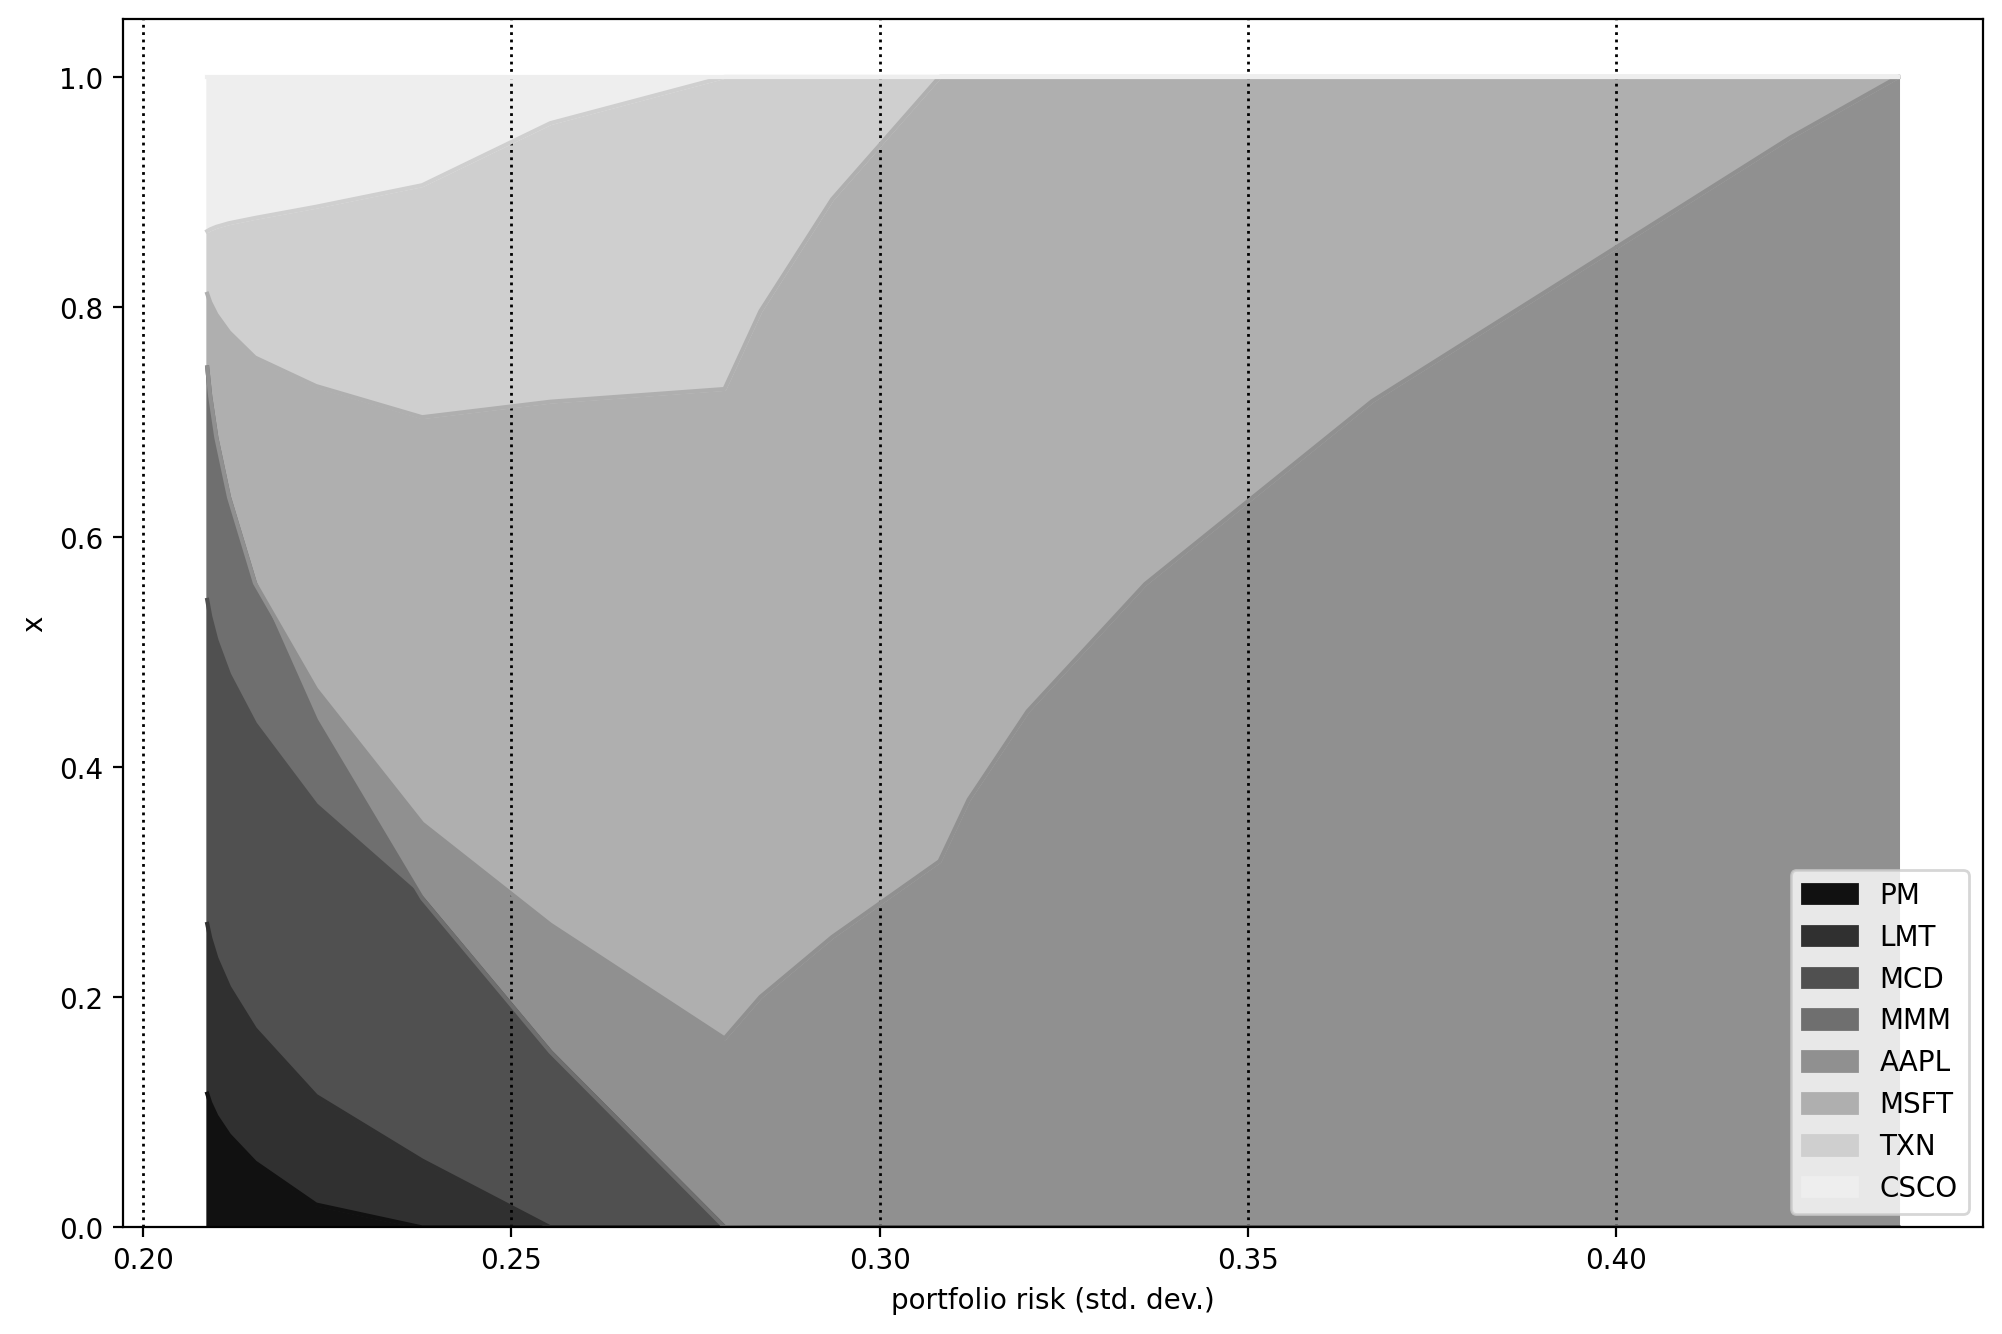

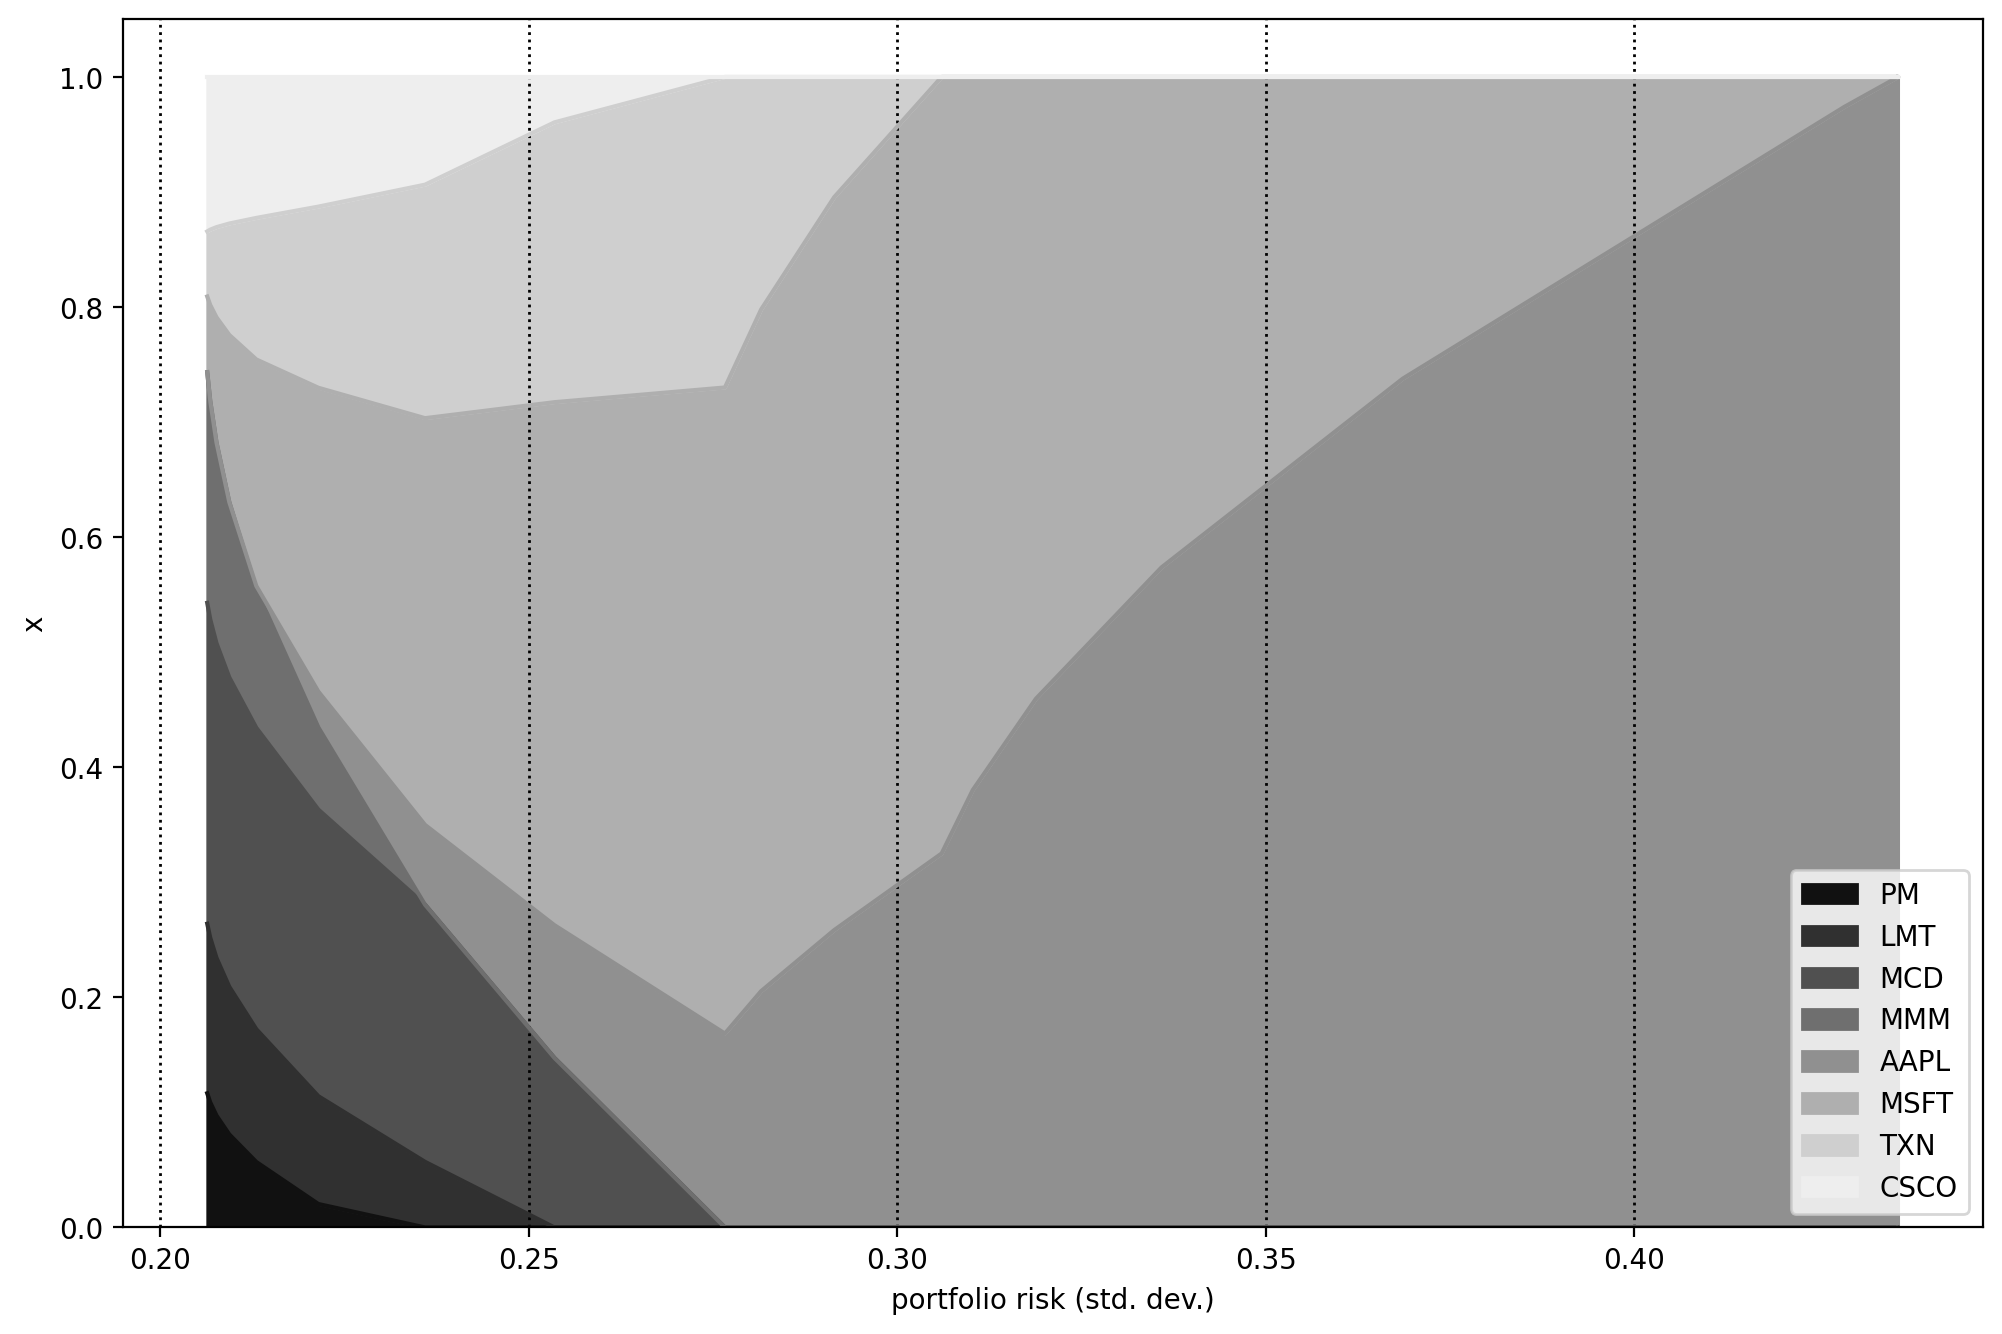

In [29]:
# Plot portfolio composition
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax1 = df_result_robust.set_index('risk').iloc[:, 4:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x")
ax1.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)
ax2 = df_result_orig.set_index('risk').iloc[:, 4:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x") 
ax2.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)